In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import librosa
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import librosa.display
from IPython.display import Audio

In [4]:
#audio path
dataset_path = '/kaggle/input/common-language/CommonLanguage/common_voice_kpd'

In [127]:
# Fungsi untuk memvisualisasikan data audio
def visualize_audio(audio_data, sample_rate):
    try:
        fig, ax = plt.subplots(5, 1, figsize=(12, 20))
        
        # Plot waveplot
        librosa.display.waveshow(audio_data, sr=sample_rate, ax=ax[0])
        ax[0].set(title='Waveplot')
        
        # Plot mel-spectrogram
        mel_spect = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        img = librosa.display.specshow(mel_spect_db, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax[1])
        fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
        ax[1].set(title='Mel-Spectrogram')
        
        # Plot chroma feature
        stft = np.abs(librosa.stft(audio_data))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        img = librosa.display.specshow(chroma, sr=sample_rate, x_axis='time', y_axis='chroma', ax=ax[2])
        fig.colorbar(img, ax=ax[2])
        ax[2].set(title='Chroma Feature')
        
        # Plot spectral contrast
        spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
        img = librosa.display.specshow(spectral_contrast, sr=sample_rate, x_axis='time', ax=ax[3])
        fig.colorbar(img, ax=ax[3])
        ax[3].set(title='Spectral Contrast')
        
        # Plot tonnetz feature
        harmonic = librosa.effects.harmonic(audio_data)
        tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sample_rate)
        img = librosa.display.specshow(tonnetz, sr=sample_rate, x_axis='time', ax=ax[4])
        fig.colorbar(img, ax=ax[4])
        ax[4].set(title='Tonnetz')
        
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error encountered while parsing audio data. Error message: {str(e)}")

In [141]:
# # Fungsi untuk memuat data audio
# def load_data(dataset_path):
#     loaded_data = []
#     labels = []
#     for language_folder in os.listdir(dataset_path):
#         if os.path.isdir(os.path.join(dataset_path, language_folder)):
#             train_path = os.path.join(dataset_path, language_folder, 'train')
#             for subfolder in os.listdir(train_path):
#                 subfolder_path = os.path.join(train_path, subfolder)
#                 if os.path.isdir(subfolder_path):
#                     for file in os.listdir(subfolder_path):
#                         file_path = os.path.join(subfolder_path, file)
#                         if file_path.endswith(".wav"):
#                             try:
#                                 audio_data, sample_rate = librosa.load(file_path, sr=None)
#                                 loaded_data.append((audio_data, sample_rate))
#                                 labels.append(language_folder)
#                             except Exception as e:
#                                 print(f"Error processing file {file_path}: {e}")
#     return loaded_data, labels

In [234]:
# Fungsi untuk ekstraksi fitur
def extract_features(audio_data, sample_rate, mfcc=True, chroma=True, mel=True, contrast=True, tonnetz=True):
    try:
        # Compute STFT if chroma, contrast, or tonnetz is requested
        if chroma or contrast or tonnetz:
            stft = np.abs(librosa.stft(audio_data))
        
        # Initialize result array
        result = np.array([])
        
        # Extract MFCC features
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        
        # Extract chroma features
        if chroma:
            chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_feat))
        
        # Extract mel-spectrogram features
        if mel:
            mel_feat = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_feat))
        
        # Extract spectral contrast features
        if contrast:
            contrast_feat = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast_feat))
        
        # Extract tonnetz features
        if tonnetz:
            tonnetz_feat = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_data), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz_feat))
        
        return result
    
    except Exception as e:
        print(f"Error encountered while extracting features. Error message: {str(e)}")
        return None

In [238]:
# Fungsi untuk melakukan trimming pada data audio
def trim_silence(audio_data, sample_rate):
    trimmed_audio, index = librosa.effects.trim(audio_data,top_db=15, hop_length=32))
    return trimmed_audio, index

In [239]:
# Fungsi untuk ekstraksi fitur menggunakan MFCC
def extract_features(audio_data, sample_rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

In [241]:
# Load data and extract features
def load_data(dataset_path):
    features = []
    labels = []
    for language_folder in os.listdir(dataset_path):
        if os.path.isdir(os.path.join(dataset_path, language_folder)):
            train_path = os.path.join(dataset_path, language_folder, 'train')
            for subfolder in os.listdir(train_path):
                subfolder_path = os.path.join(train_path, subfolder)
                if os.path.isdir(subfolder_path):
                    for file in os.listdir(subfolder_path):
                        file_path = os.path.join(subfolder_path, file)
                        if file_path.endswith(".wav"):
                            try:
                                audio_data, sample_rate = librosa.load(file_path, sr=None)
                                trimmed_audio, _ = trim_silence(audio_data, sample_rate)
                                data = extract_features(trimmed_audio, sample_rate)
                                features.append(data)
                                labels.append(language_folder)
                            except Exception as e:
                                print(f"Error processing file {file_path}: {e}")
    return np.array(features), np.array(labels)

### Load dan trim audio file

In [242]:
# Load data
features, labels = load_data(dataset_path)

KeyboardInterrupt: 

In [131]:
len(file_paths)

22196

In [148]:
len(labels)

22196

In [99]:
# Memainkan audio menggunakan IPython.display.Audio
Audio(data=audio_data, rate=sample_rate)

In [118]:
# Trim silent parts
trimmed_audio, _ = librosa.effects.trim(audio_data, top_db=15, hop_length=32)

In [119]:
#play trimmed audio
Audio(data=trimmed_audio, rate=sample_rate)

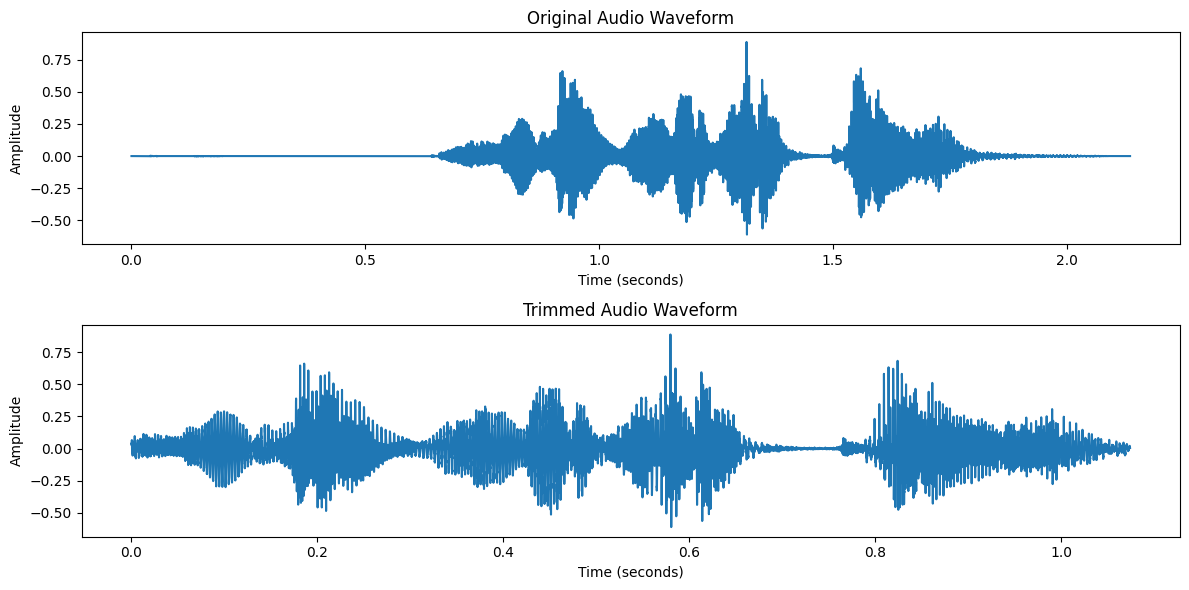

In [115]:
# Plot original and trimmed audio waveforms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(np.arange(len(audio_data)) / float(sample_rate), audio_data)
plt.title('Original Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(trimmed_audio)) / float(sample_rate), trimmed_audio)
plt.title('Trimmed Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

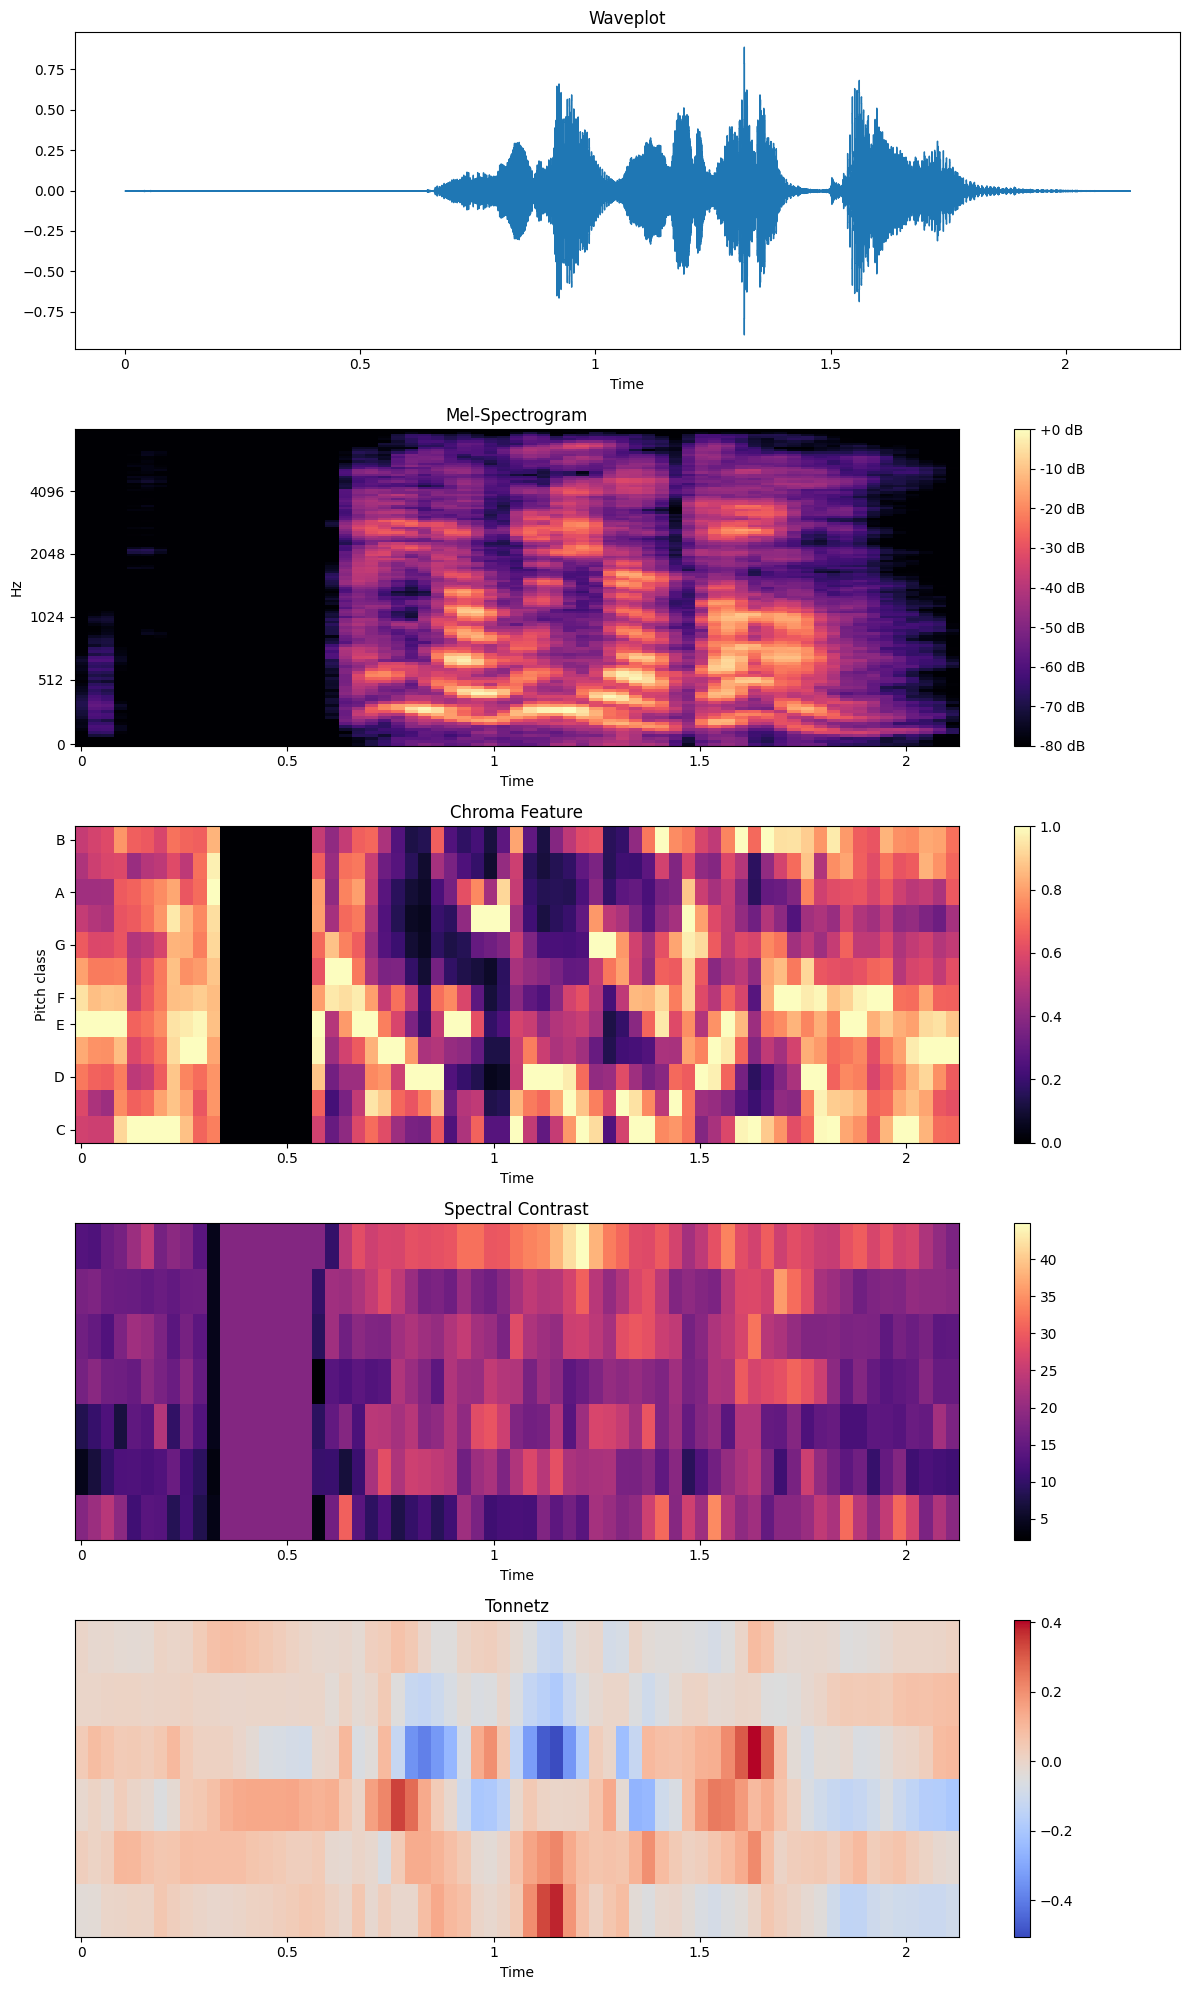

In [128]:
visualize_audio(audio_data, sample_rate)

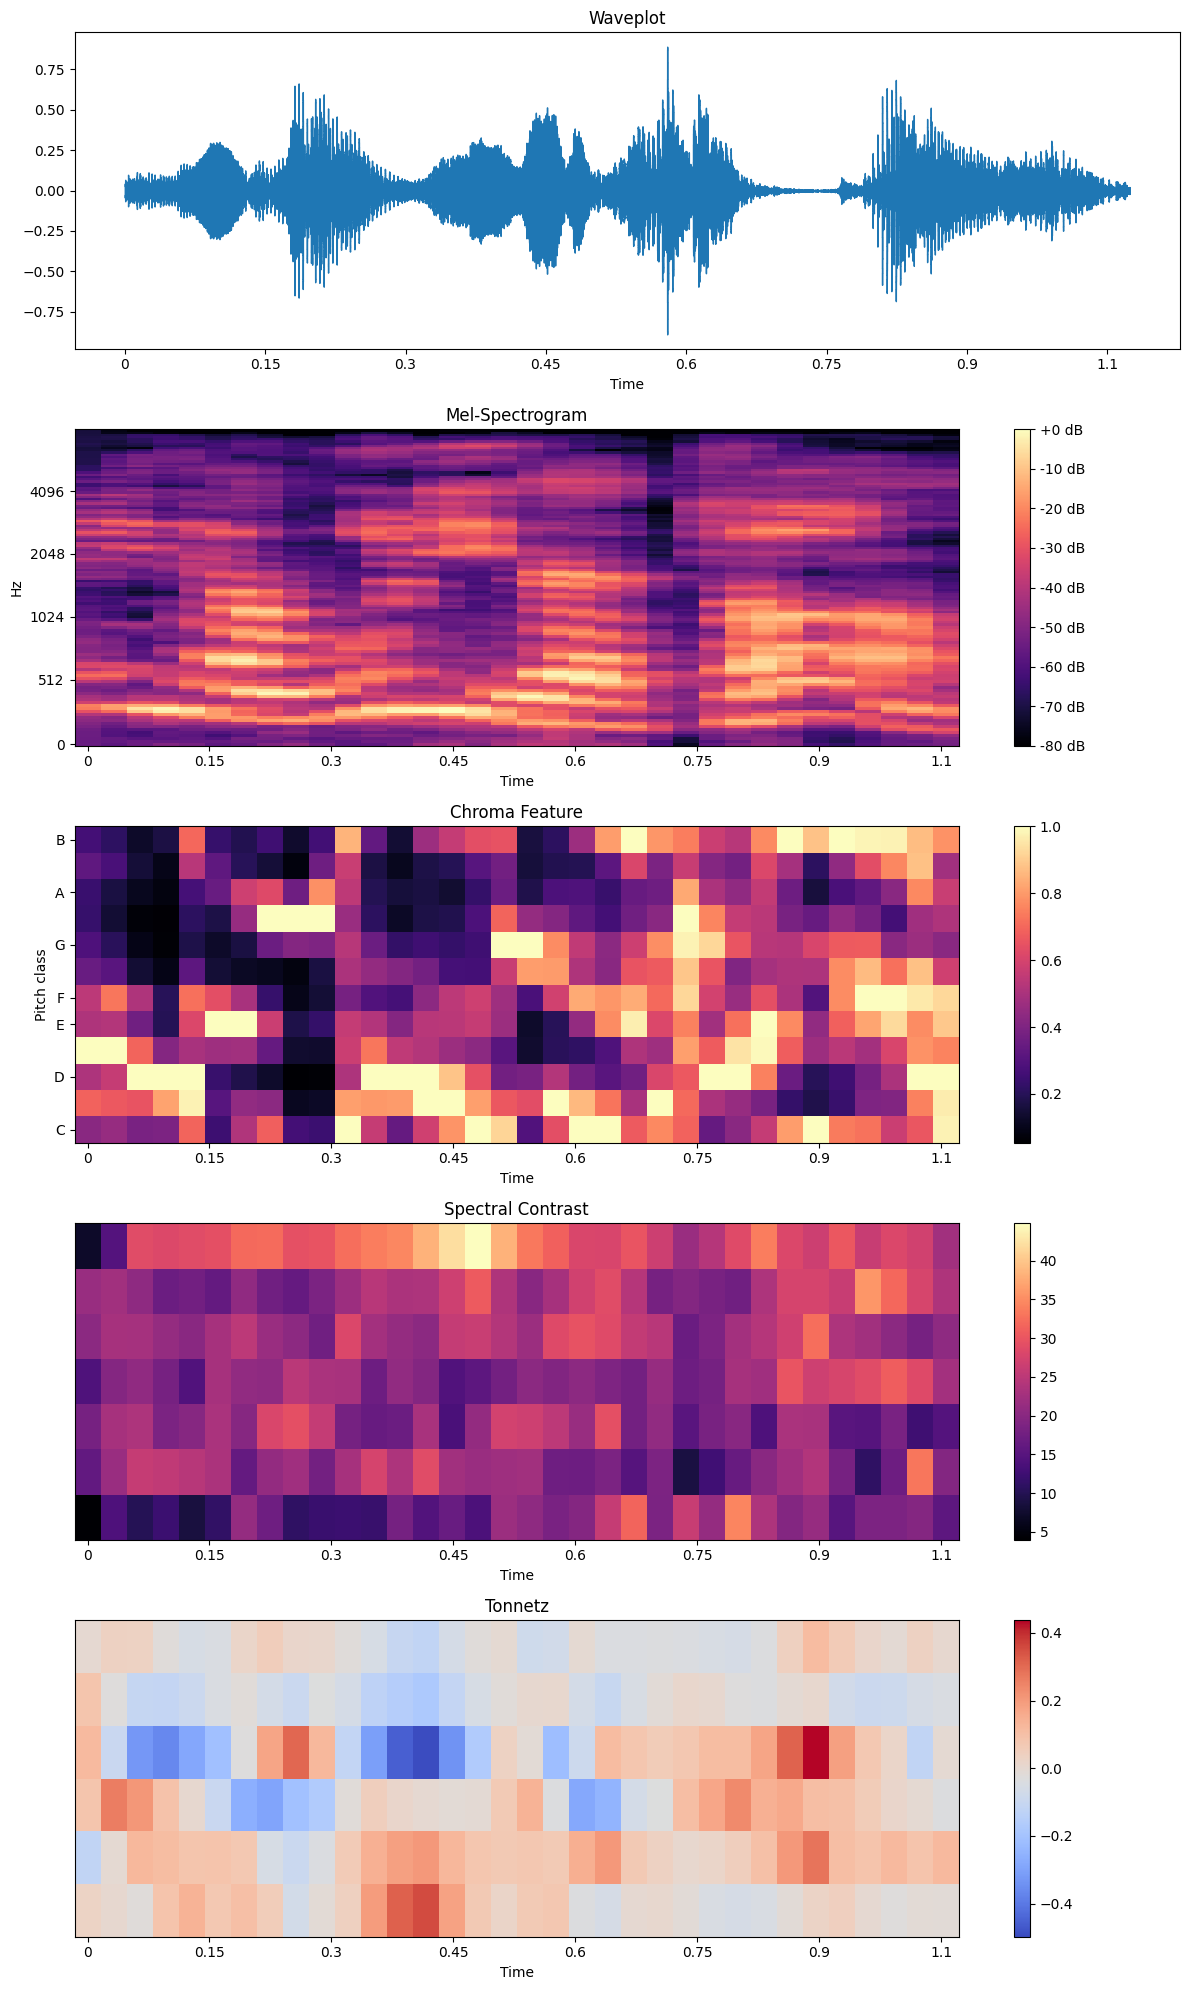

In [129]:
visualize_audio(trimmed_audio, sample_rate)

### Ekstrak fitur

In [170]:
# Fungsi untuk ekstraksi fitur MFCC menggunakan torchaudio
def extract_mfcc(audio_data, sample_rate, n_mfcc=13):
    mfcc_transform = MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc)
    mfccs = mfcc_transform(audio_data.to(device)).detach().cpu().numpy()  # Memindahkan data ke perangkat dan kembali ke CPU untuk NumPy array
    return mfccs.mean(axis=-1)

In [137]:
# Ekstraksi fitur dari data yang sudah di-trim
features = [extract_features(data, sr) for data, sr in trimmed_data]
labels = np.array(labels)

KeyboardInterrupt: 

### Learning Curve

In [19]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve

# def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'):
#     """
#     Generate a simple plot of the test and training learning curve.

#     Parameters
#     ----------
#     estimator : object
#         An object of that type which is cloned for each validation.
#         This object is assumed to implement the scikit-learn estimator interface.

#     title : string
#         Title for the chart.

#     X : array-like, shape (n_samples, n_features)
#         Training vector, where n_samples is the number of samples and
#         n_features is the number of features.

#     y : array-like, shape (n_samples) or (n_samples, n_features)
#         Target relative to X for classification or regression;
#         None for unsupervised learning.

#     cv : int, cross-validation generator or an iterable, optional
#         Determines the cross-validation splitting strategy.
#         Default is 5-fold cross-validation.

#     n_jobs : int or None, optional (default=None)
#         Number of jobs to run in parallel.
#         None means 1 unless in a joblib.parallel_backend context.
#         -1 means using all processors.

#     train_sizes : array-like, shape (n_ticks,), dtype float or int
#         Relative or absolute numbers of training examples that will be used to
#         generate the learning curve. If the dtype is float, it is regarded as a
#         fraction of the maximum size of the training set (that is determined
#         by the selected validation method), i.e. it has to be within (0, 1].
#         Otherwise it is interpreted as absolute sizes of the training sets.

#     scoring : string, callable or None, optional, default: None
#         A string (see model evaluation documentation) or a scorer callable object / function with
#         signature scorer(estimator, X, y).
#     """
#     plt.figure()
#     plt.title(title)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")

#     train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1, color="red")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="blue")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="blue", label="Cross-validation score")

#     plt.legend(loc="best")
#     plt.show()

In [20]:
# plot_learning_curve(model, "Learning Curve for Gradient Classifier", X_train2, y_train2)